- Possible -> normalize dataset (subtract mean and divide by std)
- add batch / group norm to CNN
- learning rate scheduler?

### Imports

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms.functional import convert_image_dtype
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
# import matplotlib.pyplot as plt
from pathlib import Path

# check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cpu


In [2]:
# n_layers = 3                # not implemented yet
# input_size = (1, 130, 60)      # not implemented yet
# output_channel = (20, 5, 8)
# kernel_size = (7, 5, 3)
# padding = (3, 2, 5)
# stride = (2, 3, 4)
# outputs = 3

# def fc_neurons(n_layers, input_size, output_channel, kernel_size, padding, stride):
#      for i in range(n_layers):
#           print(input_size, i)
#           input_size = [output_channel[i], int((input_size[1]+2*padding[i]-(kernel_size[i]-1))/stride[i]), int((input_size[2]+2*padding[i]-(kernel_size[i]-1))/stride[i])]
#           print(input_size)
#           input_size = [output_channel[i], int(input_size[1]/2), int(input_size[2]/2)]
#           print(input_size)
#      neurons = input_size[0] * input_size[1] * input_size[2]
#      return neurons

# print(fc_neurons(n_layers, input_size, output_channel, kernel_size, padding, stride)) # function doesnt work 

### Parameters Dashboard

In [3]:
# CNN Architecture
n_layers = 3                # not implemented yet
input_size = (1, 130, 60)      # not implemented yet
output_channel = (64, 16, 16)
kernel_size = (3, 3, 3)
padding = (1, 1, 1)
stride = (1, 1, 1)
outputs = 3

# Training parameters
num_epochs = 20
label_smoothing = 0.0
learning_rate = 0.0015

In [4]:
def fc_neurons(n_layers, input_size, output_channel, kernel_size, padding, stride):
     for i in range(n_layers):
          input_size = [output_channel[i], int((input_size[1]+2*padding[i]-(kernel_size[i]-1))/stride[i]), int((input_size[2]+2*padding[i]-(kernel_size[i]-1))/stride[i])]
          input_size = [output_channel[i], int(input_size[1]/2), int(input_size[2]/2)]
     neurons = input_size[0] * input_size[1] * input_size[2]
     return neurons

print(fc_neurons(n_layers, input_size, output_channel, kernel_size, padding, stride)) # function doesnt work 

model_name = f"test-CNN-e{num_epochs}-ls{label_smoothing}-lr{learning_rate}".replace(".", "_")

cfg={"architecture": "CNN",
     "epochs": num_epochs,
     "learning_rate": learning_rate,
     "label_smoothing": label_smoothing,
     "input_size": input_size,
     "output_channels": output_channel,
     "kernel_sizes": kernel_size,
     "padding": padding,
     "stride": stride,
     "fc_layer": (48, outputs)
     }

1792


### Data

In [5]:
# Create dataset class
class DroneImagesDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.annotations = np.genfromtxt(csv_file, delimiter=',', dtype=None, encoding=None, skip_header=True)
        self.transform = transform

    def __getitem__(self, index):
        img_path = self.annotations[index][0]
        img_path = str(Path(img_path))
        image = convert_image_dtype(read_image(img_path), torch.float)
        left, forward, right = float(self.annotations[index][1]), float(self.annotations[index][2]), float(self.annotations[index][3])
        y_label = torch.tensor([left, forward, right])
        
        if self.transform:
            image = self.transform(image)

        return (image, y_label)
    
    def __len__(self):
        return len(self.annotations)

In [6]:
# to try: bilinear, bicubic or nearest exact
IMAGE_TRANSFORM = transforms.Compose([
    transforms.CenterCrop((520, 120)),
    transforms.Grayscale(),
    transforms.Resize((26, 12), interpolation=transforms.InterpolationMode.NEAREST_EXACT),
])

In [7]:
val_ratio = 0.2
test_ratio = 0.1
batch_size = 128
dataset = DroneImagesDataset(csv_file='labeled_images.csv', transform=IMAGE_TRANSFORM)

# Split the dataset into training, validation, and test sets
num_samples = len(dataset)
num_val_samples = int(val_ratio * num_samples)
num_test_samples = int(test_ratio * num_samples)
num_train_samples = num_samples - num_val_samples - num_test_samples
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [num_train_samples, num_val_samples, num_test_samples]
)

# Create DataLoaders for the training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, prefetch_factor=2, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=2, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=2, persistent_workers=True)

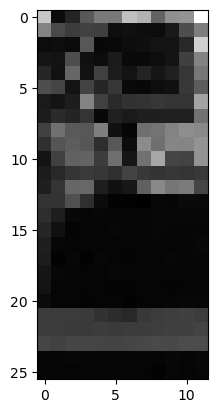

In [8]:
import matplotlib.pyplot as plt
# # show first 5 grayscale image
# for i, (image, y_label) in enumerate(train_loader):
#     if i < 5:
#         plt.imshow(image[0][0], cmap='gray')
#         plt.show()
#     else:
#         break

for i, image in enumerate(dataset):
    # dtore transform
    plt.imshow(image[0][0], cmap='gray')
    transform = dataset.transform
    dataset.transform = None
    #plt.imshow(dataset[i][0][0], cmap='gray')
    dataset.transform = transform
    break


### Lightning module

In [9]:
class LightningCNN(L.LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.save_hyperparameters(cfg)
        self.model = torch.nn.Sequential(
            # Convolutional layer 1
            torch.nn.Conv2d(self.hparams.input_size[0], self.hparams.output_channels[0], kernel_size=self.hparams.kernel_sizes[0], stride=self.hparams.stride[0], padding=self.hparams.padding[0]),
            torch.nn.BatchNorm2d(self.hparams.output_channels[0]),
            torch.nn.MaxPool2d(kernel_size=(2,2), stride=2),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.025),
            # Convolutional layer 2
            torch.nn.Conv2d(self.hparams.output_channels[0], self.hparams.output_channels[1], kernel_size=self.hparams.kernel_sizes[1], stride=self.hparams.stride[1], padding=self.hparams.padding[1]),
            torch.nn.BatchNorm2d(self.hparams.output_channels[1]),
            torch.nn.MaxPool2d(kernel_size=(2,2), stride=2),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.025),
            # Convolutional layer 3
            torch.nn.Conv2d(self.hparams.output_channels[1], self.hparams.output_channels[1], kernel_size=self.hparams.kernel_sizes[2], stride=self.hparams.stride[2], padding=self.hparams.padding[2]),
            torch.nn.BatchNorm2d(self.hparams.output_channels[1]),
            torch.nn.MaxPool2d(kernel_size=(2,2), stride=2),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.025),
            # Fully connected layer
            torch.nn.Flatten(),
            torch.nn.Linear(self.hparams.fc_layer[0], self.hparams.fc_layer[1]),
        )

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y, label_smoothing=self.hparams.label_smoothing)
        loss.backward(retain_graph=True)
        acc = torch.sum(torch.argmax(y_hat, dim=1) == torch.argmax(y, dim=1)) / len(y)
        self.log("train/loss", loss)
        self.log("train/acc", acc)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        acc = torch.sum(torch.argmax(y_hat, dim=1) == torch.argmax(y, dim=1)) / len(y)
        self.log("val/loss", loss)
        self.log("val/acc", acc)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        acc = torch.sum(torch.argmax(y_hat, dim=1) == torch.argmax(y, dim=1)) / len(y)
        self.log("test/loss", loss)
        self.log("test/acc", acc)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

In [10]:
wand_blogger = WandbLogger(project="MAV-CNN-Project")
early_stop_callback = EarlyStopping(monitor="val/acc", min_delta=0.005, patience=10, verbose=False, mode="max")
trainer = L.Trainer(max_epochs=cfg["epochs"], logger=wand_blogger, default_root_dir=f"lightning_logs/{model_name}", callbacks=[early_stop_callback])
model = LightningCNN(cfg)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Train

In [11]:
trainer.fit(model, train_loader, val_loader)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: timdb. Use `wandb login --relogin` to force relogin



  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 12.5 K
-------------------------------------
12.5 K    Trainable params
0         Non-trainable params
12.5 K    Total params
0.050     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


### Save to onnx

In [14]:
# Save model to onnx
if True:
    model.eval()
    dummy_input = torch.randn(1, 1, 130, 60)
    dummy_input = torch.randn(1, 1, 26, 15)
    torch.onnx.export(model, dummy_input, f"{model_name}.onnx")

wandb: Network error (ConnectionError), entering retry loop.


In [ ]:
test = trainer.test(model, test_loader)

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.5790795087814331     │
│         test/loss         │    0.9120391011238098     │
└───────────────────────────┴───────────────────────────┘

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Error while calling W&B API: run timdb/MAV-CNN-Project/wcelzp78 was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run timdb/MAV-CNN-Project/wcelzp78 was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run timdb/MAV-CNN-Project/wcelzp78 was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Error while calling W&B API: run timdb/MAV-CNN-Project/wcelzp78 was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run timdb/MAV-CNN-Project/wcelzp78 was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while c

In [15]:
model

LightningCNN(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Dropout(p=0.025, inplace=False)
    (5): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Dropout(p=0.025, inplace=False)
    (10): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): ReLU()
    (14): Dropout(p=0.025, inplace=False)
    (15): Flatten(start_dim=1

In [24]:
img_1 = 'tmp/70251465.jpg'
img_2 = 'tmp/84918044.jpg'

img_1 = IMAGE_TRANSFORM(convert_image_dtype(read_image(img_1), torch.float))
img_2 = IMAGE_TRANSFORM(convert_image_dtype(read_image(img_2), torch.float))

img_1 = img_1.reshape(1, *img_1.shape)
img_2 = img_2.reshape(1, *img_2.shape)

with torch.no_grad():
    model.eval()
    print(model(img_1))
    print(model(img_2))
    model.train()


tensor([[-1.3964, -1.6896,  2.6316]])
tensor([[ 0.3494, -2.4129,  0.8073]])
